### load in packages and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os,random, math, psutil, pickle 
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import calendar
from datetime import datetime
from  matplotlib.ticker import FuncFormatter

In [2]:
# read in train datasets
train_df = pd.read_csv('train.csv')
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"], format='%Y-%m-%d %H:%M:%S')

In [3]:
building_df = pd.read_csv('building_metadata.csv')
weather_train_df = pd.read_csv('weather_train.csv')

In [4]:
'''Reading in data'''
df = pd.read_pickle('tz_aware_merged_data_weather_imputed.pkl')

In [5]:
df['date'] = df.timestamp.dt.date
df['month']= df.timestamp.dt.month

### Charts

#### Missing meter reading data chart

In [ ]:
'''The codes below show a graph of 0 meter_reading values vs. non-zero
    values as we suspect some of these 0 values are actually missing
    data.      
    The codes below takes a long time to run. Use with caution.'''

train = train_df.set_index(['timestamp'])
f,a = plt.subplots(figsize=(11,5))
for meter in range(0,1):
    df = train[train.meter == meter].copy().reset_index()
    df['timestamp'] = df['timestamp'] - df['timestamp'].min() 
    df['timestamp'] = df['timestamp'].apply (lambda x: x.days*24+x.seconds//3600) #convert datetime to time index
    df['timestamp'] = df ['timestamp'].astype(int)
    missmap = np.empty((df.timestamp.max()+1, 1449)) # creating an empty array (building on x-axis, time on y)
    missmap.fill(np.nan)
    for i in df.values:
        if i[2] != meter:
            continue
        elif i[3] ==0:
            missmap[int(i[0]), int(i[1])] = 0 
        else:
            missmap[int(i[0]), int(i[1])] = 1
    sns.heatmap(missmap, cmap ='Paired', cbar = False)
    a.set_xlabel('Building')
    a.set_ylabel('Time')
    a.set_title('Potential Missing Meter Reading Data')

#### Mising weather and buidling data

In [6]:
building_df.columns

Index(['site_id', 'building_id', 'primary_use', 'square_feet', 'year_built',
       'floor_count'],
      dtype='object')

In [7]:
building_missing = pd.DataFrame(building_df.isna().sum(axis= 0 ))
building_missing=building_missing.rename(columns ={0: 'Count'})

In [8]:
building_missing['Percent'] = building_missing['Count']/len(building_df)*100

In [9]:
building_missing = building_missing.sort_values (by='Percent', ascending = False)
building_missing

,Count,Percent
floor_count,1094,75.500345
year_built,774,53.416149
site_id,0,0.000000
building_id,0,0.000000
primary_use,0,0.000000
square_feet,0,0.000000


In [10]:
weather_missing = pd.DataFrame(weather_train_df.isna().sum(axis= 0 ))
weather_missing=weather_missing.rename(columns ={0: 'Count'})
weather_missing['Percent'] = weather_missing['Count']/len(weather_train_df)*100
weather_missing= weather_missing.sort_values (by='Percent', ascending = False)
weather_missing

,Count,Percent
cloud_coverage,69173,49.489529
precip_depth_1_hr,50289,35.979052
sea_level_pressure,10618,7.596603
wind_direction,6268,4.484414
wind_speed,304,0.217496
dew_temperature,113,0.080845
air_temperature,55,0.039350
site_id,0,0.000000
timestamp,0,0.000000


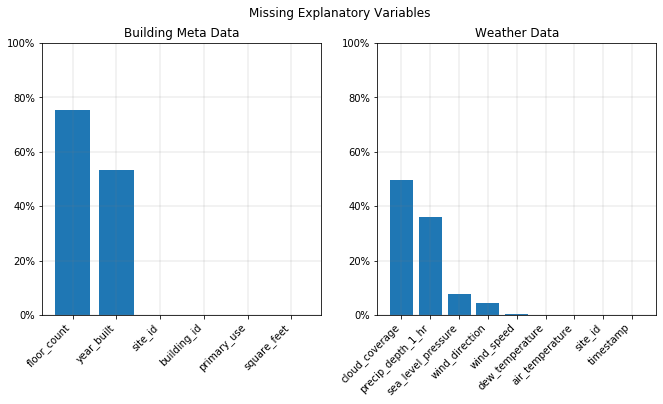

In [11]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(11,5))
axes[0].bar(building_missing.index, building_missing.Percent)
axes[0].set_ylim (0,100)
axes[0].set_xticklabels(building_missing.index, rotation=45, ha='right')
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter())
axes[0].set_title("Building Meta Data")
axes[0].grid(linestyle='-', linewidth='0.2', color='grey')

axes[1].bar(weather_missing.index, weather_missing.Percent)
axes[1].set_ylim (0,100)
axes[1].set_xticklabels(weather_missing.index, rotation=45, ha='right')
axes[1].yaxis.set_major_formatter(mtick.PercentFormatter())
axes[1].set_title("Weather Data")
axes[1].grid(linestyle='-', linewidth='0.2', color='grey')
fig.suptitle("Missing Explanatory Variables")
plt.show()


In [12]:
building_missing

,Count,Percent
floor_count,1094,75.500345
year_built,774,53.416149
site_id,0,0.000000
building_id,0,0.000000
primary_use,0,0.000000
square_feet,0,0.000000


In [13]:
weather_missing

,Count,Percent
cloud_coverage,69173,49.489529
precip_depth_1_hr,50289,35.979052
sea_level_pressure,10618,7.596603
wind_direction,6268,4.484414
wind_speed,304,0.217496
dew_temperature,113,0.080845
air_temperature,55,0.039350
site_id,0,0.000000
timestamp,0,0.000000


### final clean data charts

#### Heatmap by primary use (daily usage)

In [ ]:
df.head(5)

In [651]:
def get_num_outliers (column):
    average
    q1 = np.percentile(column, 25)
    q3 = np.percentile(column, 75)
    return sum((column<q1) | (column>q3))

In [530]:
pivot_date_type = pd.pivot_table(df, index=['month'], columns=['primary_use'],values=['meter_reading'],aggfunc=np.mean)

In [531]:
xlabel = []
for key, groups in df.groupby(['primary_use']):
    xlabel += [key]

yticks =[]
for i in range (1,13):
    yticks += [calendar.month_abbr[i]]

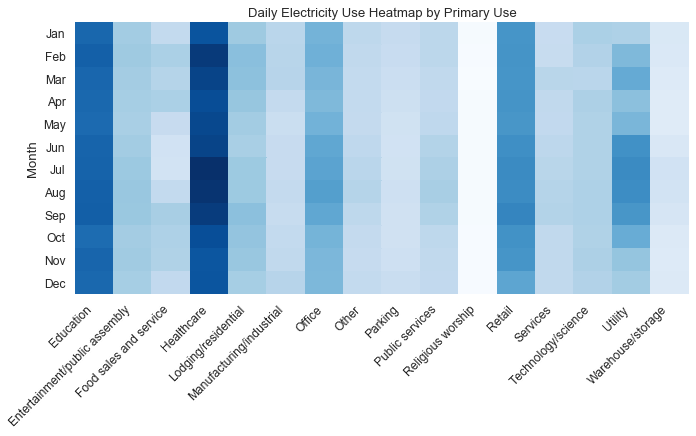

In [532]:
fig, ax = plt.subplots(figsize=(11,5))
xticks = np.array(xlabel)

sns.heatmap(pivot_date_type, cmap ='Blues',xticklabels=xticks,yticklabels=yticks, cbar = False)

ax.set_xlabel('')
ax.set_ylabel('Month')
ax.set_title('Daily Electricity Use Heatmap by Primary Use')
ax.set_xticklabels(xticks, rotation=45, ha='right')

plt.show()

#### Heatmap by site (daily usage)

In [80]:
pivot_site_date = pd.pivot_table(df.loc[~df.location.isna()], index=['date'], columns=['site_id'],values=['meter_reading'],aggfunc=np.mean)

In [81]:
site_id_location = {0:'Site 0: FL', 1:'Site 1: UK', 2: 'Site 2: AZ', 3: 'Site 3: WA', 4:'Site 4: CA',\
                   5: 'Site 5: UK', 6:'Site 6: PA', 7: 'Site 7: Canada', 8: 'Site 8: FL', 9: 'Site 9: TX',\
                   10: 'Site 10: NV', 11: 'Site 11: Canada', 12:'Site 12: Ireland', 13: 'Site 13: MN', 14: 'Site 14: VA',\
                   15: 'Site 15: PA'}

In [82]:
xlabel = []
df1= df.loc[~df.location.isna()]
mapping = df1.loc[:,df1.columns.isin(['site_id','location'])]
for key, groups in mapping.groupby(['site_id']):
    xlabel += [site_id_location[key]]



In [83]:
xlabel

['Site 0: FL',
 'Site 1: UK',
 'Site 2: AZ',
 'Site 3: WA',
 'Site 4: CA',
 'Site 5: UK',
 'Site 6: PA',
 'Site 7: Canada',
 'Site 8: FL',
 'Site 9: TX',
 'Site 10: NV',
 'Site 11: Canada',
 'Site 12: Ireland',
 'Site 13: MN',
 'Site 14: VA',
 'Site 15: PA']

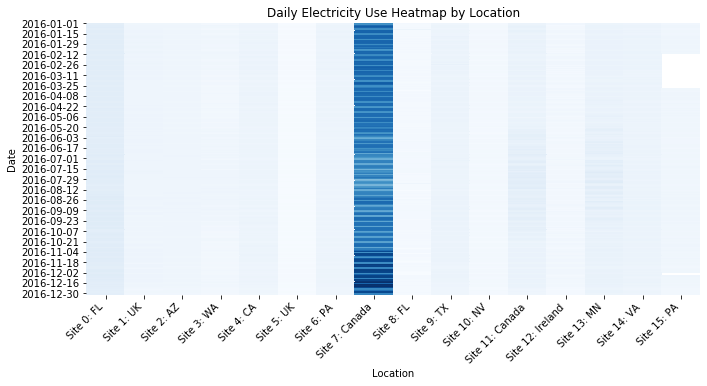

In [84]:
fig, ax = plt.subplots(figsize=(11,5))
xticks = np.array(xlabel)

sns.heatmap(pivot_site_date, cmap ='Blues',xticklabels=xticks, cbar = False)

ax.set_xlabel('Location')
ax.set_ylabel('Date')
ax.set_title('Daily Electricity Use Heatmap by Location')
ax.set_xticklabels(xticks, rotation=45, ha='right')

plt.show()

version 2`

In [85]:
canada = pd.DataFrame(df.loc[df.location == 'Montreal/Ottawa'].groupby('timestamp')['air_temperature'].mean())

In [86]:
other = pd.DataFrame(df.loc[df.location != 'Montreal/Ottawa'].groupby('timestamp')['air_temperature'].mean())

In [87]:
canada_vs_other_temp = pd.merge(canada, other, left_index=True, right_index=True)
canada_vs_other_temp.rename(columns = {'air_temperature_x':'canada', 'air_temperature_y':'other'}, inplace = True)

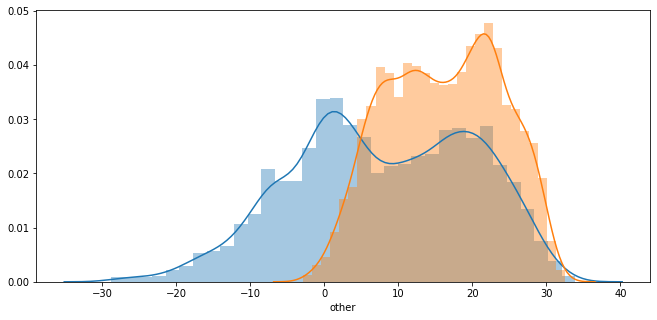

In [88]:
fig, ax = plt.subplots(figsize=(11,5))

sns.distplot(canada_vs_other_temp.canada, ax = ax)
sns.distplot(canada_vs_other_temp.other, ax = ax)

plt.show()

In [89]:
pivot_site_hour_sum= pd.pivot_table(df.loc[~df.location.isna()], index=['month'], columns=['site_id'],values=['meter_reading'],aggfunc=np.sum)
pivot_site_hour = pd.pivot_table(df.loc[~df.location.isna()], index=['month'], columns=['site_id'],values=['meter_reading'],aggfunc=np.mean)

In [90]:
xlabel = []
df1= df.loc[~df.location.isna()]
mapping = df1.loc[:,df1.columns.isin(['site_id','location'])]
for key, groups in mapping.groupby(['site_id']):
    xlabel += [site_id_location[key]]
yticks =[]
for i in range (1,13):
    yticks += [calendar.month_abbr[i]]

In [91]:
site7 = pd.DataFrame(df.loc[df.site_id == 7].groupby('building_id')['square_feet'].mean())

In [92]:
nonsite7 = pd.DataFrame(df.loc[df.site_id != 7].groupby('building_id')['square_feet'].mean())

In [93]:
min(nonsite7.square_feet)

283

In [94]:
sqftcompare  = pd.merge(site7, nonsite7, left_index=True, right_index=True)


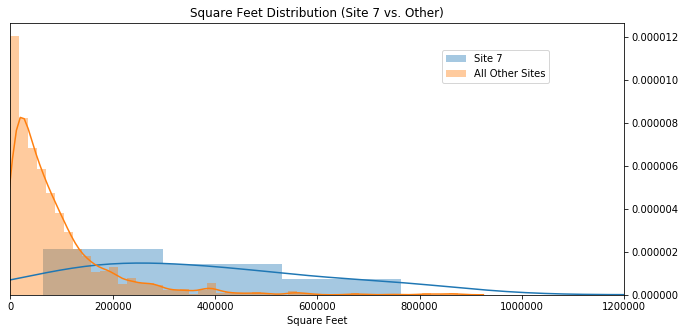

In [95]:
fig, ax = plt.subplots(figsize=(11,5))

sns.distplot(site7.square_feet, ax = ax)
sns.distplot(nonsite7.square_feet, ax = ax)
ax.set_xlim (0, 1200000)
fig.legend(labels=['Site 7','All Other Sites'], bbox_to_anchor=(0.7, 0.8))
ax.yaxis.set_label_position("right")
ax.set_xlabel('Square Feet')
ax.yaxis.tick_right()
ax.set_title('Square Feet Distribution (Site 7 vs. Other)')
plt.show()

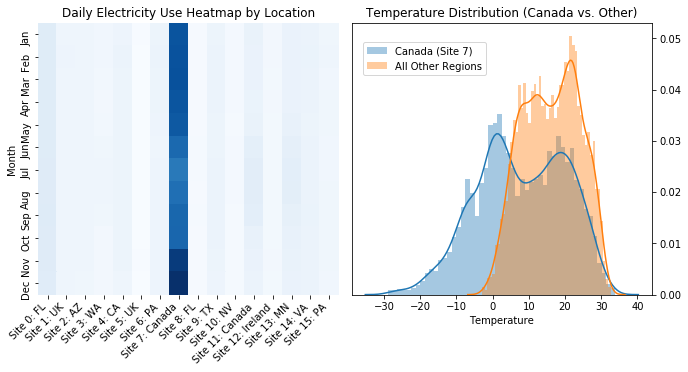

In [97]:
fig = plt.figure(figsize=(11,5))
gs = fig.add_gridspec(1, 8)

ax = fig.add_subplot(gs[0:-4])

sns.heatmap(pivot_site_hour, cmap ='Blues',xticklabels=xticks, yticklabels=yticks, cbar = False)

ax.set_xlabel('')
ax.set_ylabel('Month')
ax.set_title('Daily Electricity Use Heatmap by Location')
ax.set_xticklabels(xticks, rotation=45, ha='right')


ax2 = fig.add_subplot(gs[-4:])

l1 =sns.distplot(canada_vs_other_temp.canada, ax = ax2, bins = 50, label ='Canada (Site 7)')
l2= sns.distplot(canada_vs_other_temp.other, ax = ax2, bins = 50, label = 'All other regions')
fig.legend(labels=['Canada (Site 7)','All Other Regions'], bbox_to_anchor=(0.62, 0.93))
ax2.yaxis.set_label_position("right")
ax2.set_xlabel('Temperature')
ax2.yaxis.tick_right()
ax2.set_title('Temperature Distribution (Canada vs. Other)')


plt.show()

#### Meter reading heatmap by temperature

In [90]:
usage_by_temp = pd.DataFrame(df.groupby('air_temperature')['meter_reading'].mean())

In [91]:
bins = np.linspace(-30, 45, 50)
groups = usage_by_temp.groupby(np.digitize(usage_by_temp.index, bins))

In [92]:
count = pd.DataFrame(groups.count())

In [93]:
average_userage = pd.DataFrame(groups.mean())

In [94]:
average_userage['count'] = count['meter_reading']

In [139]:
cmap= sns.color_palette("Blues_d")

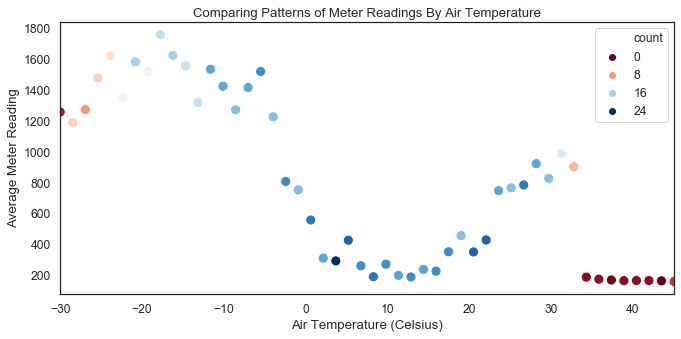

In [150]:
fig, ax = plt.subplots(figsize=(11,5))
sns.set_palette("Blues_d")
sns.scatterplot(x=bins, y='meter_reading', hue='count',palette = 'RdBu',s=100,data =average_userage)
sns.set(style= 'white', font_scale =1.1)
ax.set_xlabel('Air Temperature (Celsius)')
ax.set_ylabel('Average Meter Reading')
ax.set_title('Comparing Patterns of Meter Readings By Air Temperature')
ax.set_xlim(-30,45)
plt.show()

#### Distribution by primary use

In [588]:
primary_use_dist = df[['primary_use','meter_reading','date']]
pivot_use_date= pd.pivot_table(primary_use_dist, index=['primary_use'], columns=['date'],values=['meter_reading'],aggfunc=np.mean, margins= True)
pivot_use_date.sort_values(by=('meter_reading', 'All'), ascending=False,inplace=True)
pivot_use_date_test = pivot_use_date.unstack().reset_index().drop('level_0', axis=1)
pivot_use_date_test= pivot_use_date_test.rename(columns = {0:'meter_reading'})
pivot_use_date_test= pivot_use_date_test.loc[pivot_use_date_test.primary_use != 'All']
pivot_use_date_test= pivot_use_date_test.loc[pivot_use_date_test.date != 'All']

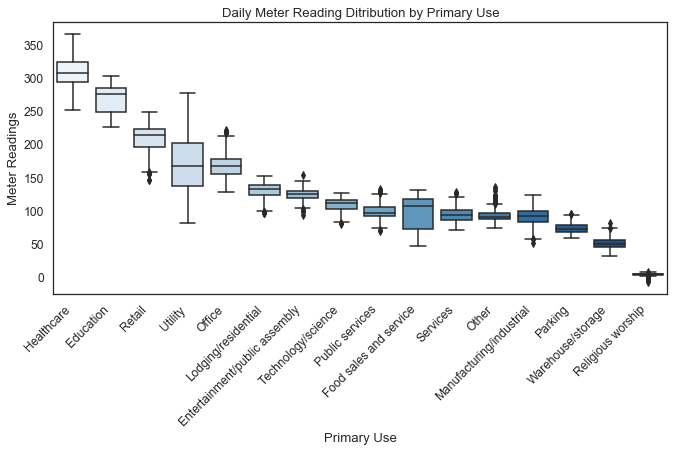

In [589]:
fig = plt.figure(figsize=(11,5))
gs = fig.add_gridspec(1, 8)

fig_ax1 = fig.add_subplot(gs[0:])
sns.set(style= 'whitegrid', font_scale =1.1)
sns.boxplot(x='primary_use', y='meter_reading', data=pivot_use_date_test, palette="Blues", ax = fig_ax1)


fig_ax1.set_xticklabels(fig_ax1.get_xticklabels(), rotation=45, ha='right')

fig_ax1.set_xlabel('Primary Use')
fig_ax1.set_ylabel('Meter Readings')
fig_ax1.set_title('Daily Meter Reading Ditribution by Primary Use')


# fig_ax2 = fig.add_subplot(gs[-1:])

# sns.boxplot(x='primary_use', y='meter_reading', data=pivot_use_date_test.loc[pivot_use_date_test.primary_use =='Religious worship'], palette="Blues", ax = fig_ax2)

# fig_ax2.set_xlabel('')
# fig_ax2.set_ylabel('Meter Readings')
# fig_ax2.set_xticklabels(fig_ax2.get_xticklabels(), rotation=45, ha='right')
# fig_ax2.yaxis.set_label_position("right")
# fig_ax2.yaxis.tick_right()

plt.show()

### outliers?

In [189]:
outlier = df[['primary_use', 'site_id', 'meter_reading','date']]

In [190]:
outlier.describe()

,site_id,meter_reading
count,1.206231e+07,1.206231e+07
mean,6.749967e+00,1.861771e+02
std,4.946893e+00,4.009262e+02
min,0.000000e+00,-4.608884e+01
25%,3.000000e+00,2.390000e+01
50%,5.000000e+00,7.102000e+01
75%,1.200000e+01,1.848960e+02
max,1.500000e+01,7.976900e+04


In [191]:
outlier_daily = pd.DataFrame(outlier.groupby('date')['meter_reading'].mean())

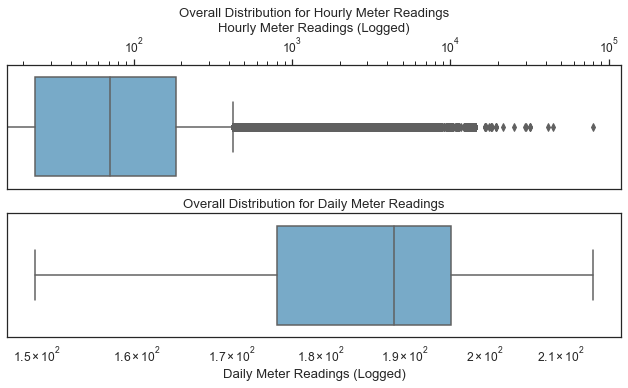

In [193]:
fig = plt.figure(figsize=(11,5))
gs = fig.add_gridspec(2, 1)

ax = fig.add_subplot(gs[0,:])
sns.boxplot(outlier.meter_reading, ax = ax, palette ='Blues')

ax.set_xscale('log')
ax.set_title('Overall Distribution for Hourly Meter Readings')
ax.set_xlabel('Hourly Meter Readings (Logged)')
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()

ax2 = fig.add_subplot(gs[1,:])
ax2.set_xscale('log')
ax2.set_title('Overall Distribution for Daily Meter Readings')
ax2.set_xlabel('Daily Meter Readings (Logged)')

sns.boxplot(outlier_daily, ax = ax2, palette ='Blues')

plt.show()

In [194]:
# Taking a look at the outliers
outlier_sub =df[['primary_use', 'site_id', 'meter_reading', 'hour_of_day','date','year_built']]

In [195]:
outlier_sub_1 = outlier_sub.loc[outlier_sub.meter_reading - outlier_sub.meter_reading.mean() >3*outlier_sub.meter_reading.mean() ]

In [ ]:
len(outlier_sub_1)/len(outlier_sub)

In [197]:
outlier_use = outlier_sub_1.pivot_table(index='site_id',columns= 'primary_use',values ='meter_reading',aggfunc=len)

In [202]:
outlier_use_pc= outlier_sub_1.pivot_table(index='site_id',columns= 'primary_use',values ='meter_reading',aggfunc=len, margins = True).div(len(df.index)).mul(100)

In [207]:
outlier_by_use = pd.DataFrame(outlier_use_pc.iloc[16])

In [212]:
outlier_by_use.rename(columns= {'All':'Outliers'}, inplace = True )
outlier_by_use.sort_values(by='Outliers',ascending = False, inplace = True)

In [214]:
outlier_by_use = outlier_by_use.loc[~outlier_by_use.index.isin(['All'])]

In [215]:
outlier_by_use

,Outliers
primary_use,
Education,2.828579
Office,0.773351
Entertainment/public assembly,0.399028
Public services,0.230147
Healthcare,0.145229
Other,0.073593
Retail,0.073444
Lodging/residential,0.062384
Utility,0.017028


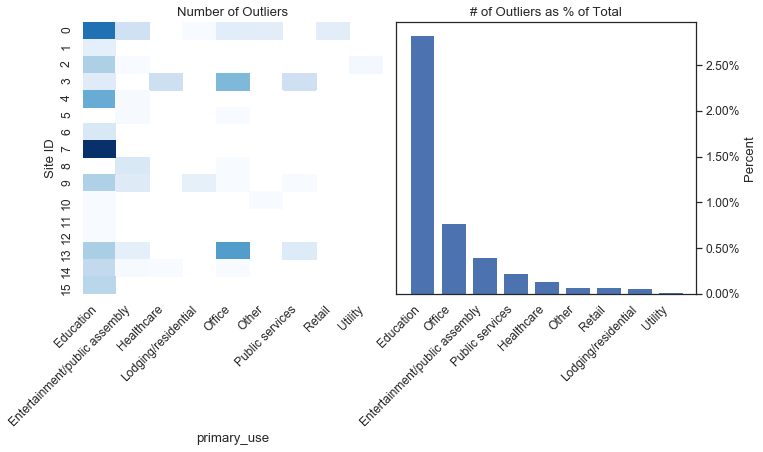

In [229]:
fig = plt.figure(figsize=(11,5))
gs = fig.add_gridspec(1, 8)

ax = fig.add_subplot(gs[0,:-4])
xticks = np.array(outlier_use.columns.to_list())

sns.heatmap(outlier_use, cmap ='Blues',xticklabels=xticks, cbar = False, ax = ax)

ax.set_title('Number of Outliers')
ax.set_ylabel('Site ID')

ax.set_xticklabels(xticks, rotation=45, ha='right')

ax2 = fig.add_subplot(gs[0,-4:])


ax2.bar(outlier_by_use.index, outlier_by_use.Outliers)
ax2.set_xticklabels(outlier_by_use.index, rotation=45, ha='right')
ax2.yaxis.set_label_position("right")
ax2.set_title('# of Outliers as % of Total')
ax2.set_ylabel('Percent')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
               
ax2.yaxis.tick_right()
plt.show()

In [276]:
outlier_hr_use= outlier_sub_1.pivot_table(index='hour_of_day',columns= 'primary_use',values ='meter_reading',aggfunc=len)

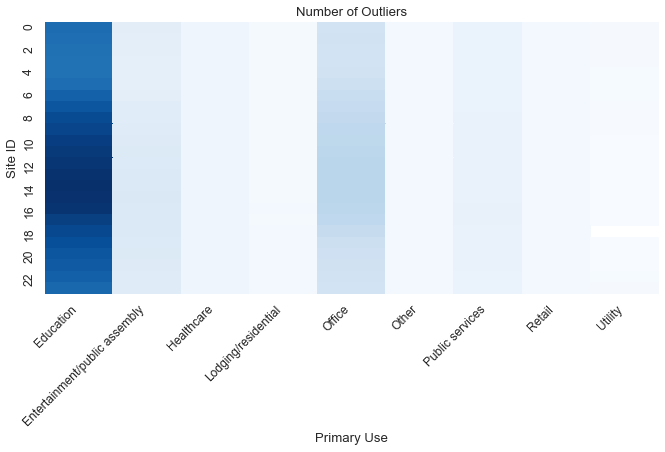

In [277]:
fig, ax = plt.subplots(figsize=(11,5))

xticks = np.array(outlier_hr_use.columns.to_list())

sns.heatmap(outlier_hr_use, cmap ='Blues',xticklabels=xticks, cbar = False, ax = ax)

ax.set_title('Number of Outliers')
ax.set_ylabel('Site ID')
ax.set_xlabel('Primary Use')
ax.set_xticklabels(xticks, rotation=45, ha='right')
plt.show()

In [384]:
#### SPikes
train_df_adj =train_df.copy()
train_df_adj ['date']= train_df['timestamp'].dt.date
train_df_adj['date'] = pd.to_datetime(train_df_adj['date'])
train_df_adj ['hour_of_day']= train_df['timestamp'].dt.hour

In [397]:
# Example 1
date ='2016-01-06'
df_spike_1= train_df_adj.loc[ (train_df_adj.building_id ==881) & (train_df_adj.date == date)]

In [420]:
# Example 1
date ='2016-11-21'
df_spike_2= train_df_adj.loc[ (train_df_adj.building_id ==53) & (train_df_adj.date == date)]

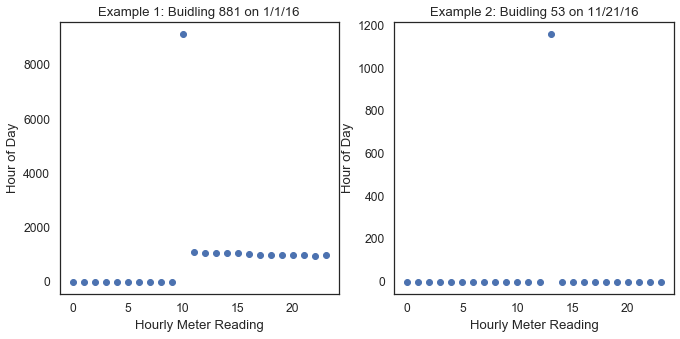

In [423]:
fig, axs = plt.subplots(1,2,figsize=(11,5))
axs[0].scatter(df_spike_1['hour_of_day'], df_spike_1['meter_reading'])
axs[0].set_title('Example 1: Buidling 881 on 1/1/16')
axs[0].set_ylabel('Hour of Day')
axs[0].set_xlabel('Hourly Meter Reading')



axs[1].scatter(df_spike_2['hour_of_day'], df_spike_2['meter_reading'])
axs[1].set_title('Example 2: Buidling 53 on 11/21/16')
axs[1].set_ylabel('Hour of Day')
axs[1].set_xlabel('Hourly Meter Reading')
plt.show()

##time of day and primary use

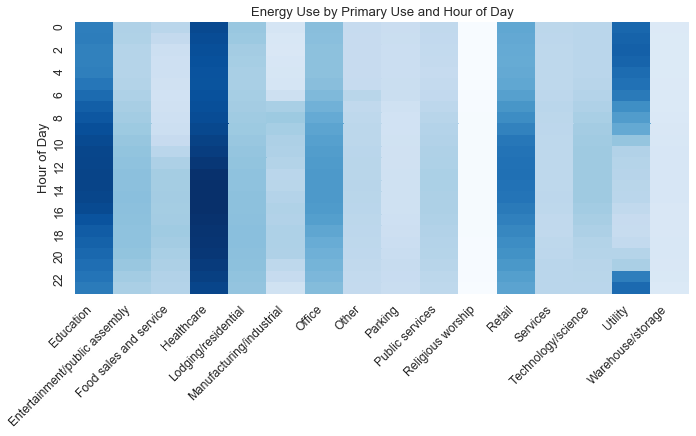

In [528]:
time_day_use= df.pivot_table(index='hour_of_day',columns= 'primary_use',values ='meter_reading',aggfunc=np.mean)
fig, ax = plt.subplots(figsize=(11,5))

xticks = np.array(time_day_use.columns.to_list())

sns.heatmap(time_day_use, cmap ='Blues',xticklabels=xticks, cbar = False, ax = ax)

ax.set_title('Energy Use by Primary Use and Hour of Day')
ax.set_ylabel('Hour of Day')
ax.set_xlabel('')
ax.set_xticklabels(xticks, rotation=45, ha='right')
plt.show()

### Time and temperature

In [151]:
df1 = df.copy()
# df1['air_temperature'] =df1['air_temperature'].apply(lambda x: int(round(x)))

In [152]:
df1['air_temperature'].min()

-28.9

In [153]:
time_temp= df1.pivot_table(index='hour_of_day',columns= 'air_temperature',values ='meter_reading',aggfunc=np.mean)


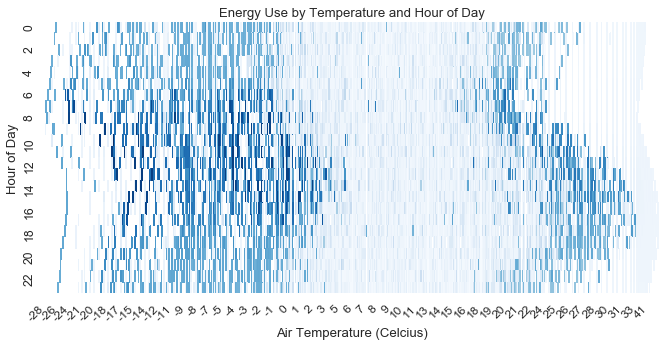

In [154]:
fig1, ax = plt.subplots(figsize=(11,5))

sns.heatmap(time_temp, cmap ='Blues', cbar = False, ax = ax)

ax.set_title('Energy Use by Temperature and Hour of Day')
ax.set_ylabel('Hour of Day')
ax.set_xlabel('Air Temperature (Celcius)')
xlabels = [int(float(item.get_text()) )for item in ax.get_xticklabels()]
ax.set_xticklabels(xlabels,fontsize=12,rotation=45, ha='right')
plt.show()

In [155]:
time_temp_2= df1.pivot_table(index='air_temperature',columns= 'hour_of_day',values ='meter_reading',aggfunc=np.mean)


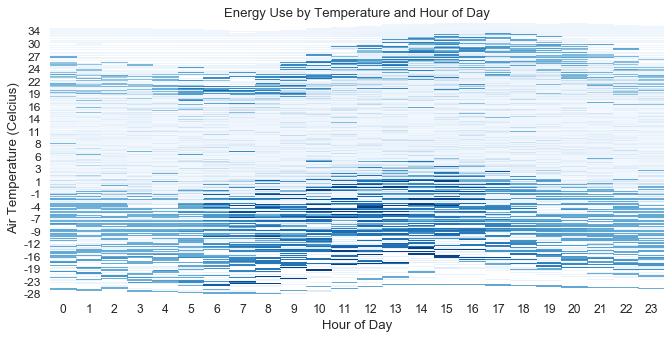

In [163]:
fig1, ax = plt.subplots(figsize=(11,5))

sns.heatmap(time_temp_2, cmap ='Blues', cbar = False, ax = ax)

ax.set_title('Energy Use by Temperature and Hour of Day')
ax.set_ylabel('Air Temperature (Celcius)')
ax.set_xlabel('Hour of Day')
ylabels = [int(float(item.get_text()) )for item in ax.get_yticklabels()]
ax.invert_yaxis()
ax.set_yticklabels(ylabels,fontsize=12,rotation=0, ha='right')
plt.show()

In [549]:
labels = [int(float(item.get_text()) )for item in ax.get_xticklabels()]

## distriobution by site

In [645]:
primary_use_dist = df[['site_id','meter_reading','date']]
pivot_use_date= pd.pivot_table(primary_use_dist, index=['site_id'], columns=['date'],values=['meter_reading'],aggfunc=np.sum, margins= True)

In [646]:
pivot_use_date.sort_values(by=('meter_reading', 'All'), ascending=False,inplace=True)

In [647]:
pivot_use_date_test = pivot_use_date.unstack().reset_index().drop('level_0', axis=1)
pivot_use_date_test= pivot_use_date_test.rename(columns = {0:'meter_reading'})
pivot_use_date_test= pivot_use_date_test.loc[pivot_use_date_test.site_id != 'All']
pivot_use_date_test= pivot_use_date_test.loc[pivot_use_date_test.date != 'All']

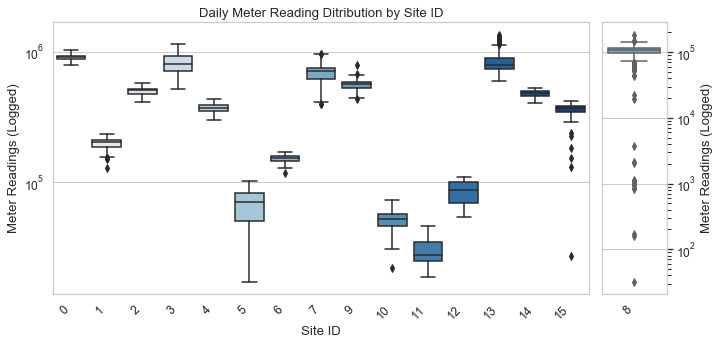

In [691]:
fig = plt.figure(figsize=(11,5))
gs = fig.add_gridspec(1, 8)

fig_ax1 = fig.add_subplot(gs[0,:-1])
sns.set(style= 'whitegrid', font_scale =1.1)
sns.boxplot(x='site_id', y='meter_reading', data=pivot_use_date_test.loc[pivot_use_date_test.site_id!=8], palette="Blues", ax = fig_ax1)
fig_ax1.set_yscale('log')

fig_ax1.set_xticklabels(fig_ax1.get_xticklabels(), rotation=45, ha='right')

fig_ax1.set_xlabel('Site ID')
fig_ax1.set_ylabel('Meter Readings (Logged)')
fig_ax1.set_title('Daily Meter Reading Ditribution by Site ID')

fig_ax2 = fig.add_subplot(gs[0,-1:])
sns.boxplot(x='site_id', y='meter_reading', data=pivot_use_date_test.loc[pivot_use_date_test.site_id ==8], palette="Blues", ax = fig_ax2)
fig_ax2.set_yscale('log')

fig_ax2.set_xticklabels(fig_ax2.get_xticklabels(), rotation=45, ha='right')

fig_ax2.set_xlabel('')
fig_ax2.set_ylabel('Meter Readings (Logged)')
fig_ax2.yaxis.set_label_position("right")
fig_ax2.yaxis.tick_right()
plt.show()

In [609]:
primary_use_dist_8 = df.loc[df.site_id ==8]
primary_use_dist_8 =primary_use_dist_8[['primary_use','meter_reading','date']]

In [611]:
pivot_use_date= pd.pivot_table(primary_use_dist_8, index=['primary_use'], columns=['date'],values=['meter_reading'],aggfunc=np.sum, margins= True)
pivot_use_date.sort_values(by=('meter_reading', 'All'), ascending=False,inplace=True)
pivot_use_date_test = pivot_use_date.unstack().reset_index().drop('level_0', axis=1)
pivot_use_date_test= pivot_use_date_test.rename(columns = {0:'meter_reading'})
pivot_use_date_test= pivot_use_date_test.loc[pivot_use_date_test.primary_use != 'All']
pivot_use_date_test= pivot_use_date_test.loc[pivot_use_date_test.date != 'All']

In [612]:
primary_use_dist_8 =pivot_use_date_test

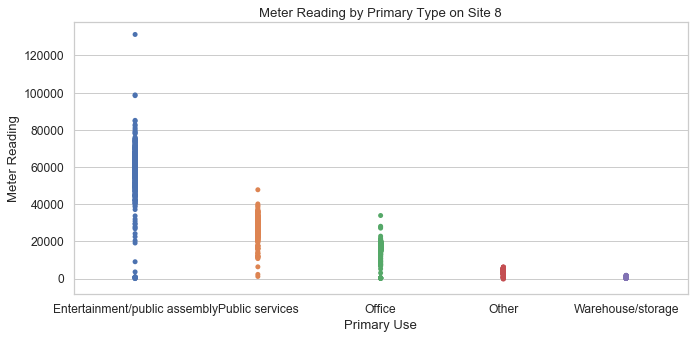

In [619]:
fig = plt.figure(figsize=(11,5))

ax = fig.add_subplot()
sns.catplot(x="primary_use", y="meter_reading", data=primary_use_dist_8, jitter=False, ax =ax)
ax.set_title('Meter Reading by Primary Type on Site 8')
ax.set_ylabel('Meter Reading')
ax.set_xlabel('Primary Use')
xlabels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels(xlabels, rotation=0, ha='center')

plt.close(2)
plt.show()

# Building charcteristic

In [15]:
building_df.isna().sum()

site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64

In [16]:
primary_use_count = pd.DataFrame(building_df.groupby('primary_use').agg(len))

In [17]:
primary_use_count= primary_use_count[['site_id']]
primary_use_count=primary_use_count.rename(columns = {'site_id': 'count'})

In [18]:
primary_use_count.sort_values(by ='count', ascending = False, inplace = True)

In [23]:
primary_use_count ['percent']= primary_use_count ['count']/len(building_df)*100

In [56]:
primary_use_count

,count,percent
primary_use,,
Education,549,37.888199
Office,279,19.254658
Entertainment/public assembly,184,12.698413
Public services,156,10.766046
Lodging/residential,147,10.144928
Other,25,1.725328
Healthcare,23,1.587302
Parking,22,1.518288
Warehouse/storage,13,0.897170


In [133]:
primary_use_trans = primary_use_count.head(5)

In [134]:
primary_use_trans= primary_use_trans.reset_index()

In [169]:
primary_use_trans

,count,percent
primary_use,,
other,134,9.247757
Lodging/residential,147,10.144928
Public services,156,10.766046
Entertainment/public assembly,184,12.698413
Office,279,19.254658
Education,549,37.888199


In [136]:
primary_use_trans = primary_use_trans.append([{'primary_use':'other', 'count':sum(primary_use_count.iloc[5:]['count']), 'percent': sum(primary_use_count.iloc[5:]['percent']) }])

In [138]:
primary_use_trans = primary_use_trans.set_index('primary_use')

In [140]:
primary_use_trans.sort_values(by='percent', inplace = True)

In [143]:
labels = list(primary_use_trans.index)


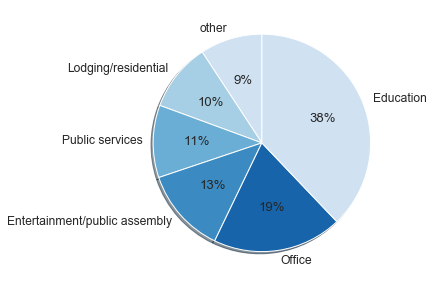

In [167]:
fig = plt.figure(figsize=(11,5))
ax = fig.add_subplot()

cmap = plt.get_cmap("Blues")
color = cmap(np.linspace(0.2, 0.8, 5))
ax.pie(primary_use_trans.percent, colors = color, labels = labels,autopct='%1.0f%%', shadow=True, startangle=90)
plt.show()

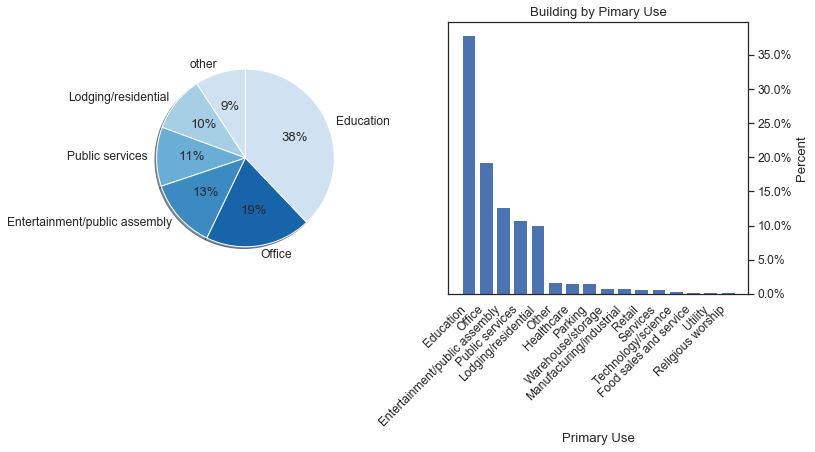

In [184]:
fig = plt.figure(figsize=(11,5))
gs = fig.add_gridspec(1, 8)
ax = fig.add_subplot(gs[0,:-5])

sns.set(style= 'white', font_scale =1.1)
cmap = plt.get_cmap("Blues")
color = cmap(np.linspace(0.2, 0.8, 5))
ax.pie(primary_use_trans.percent, colors = color, labels = labels,autopct='%1.0f%%', shadow=True, startangle=90)

ax2 = fig.add_subplot(gs[0,-4:])

ax2.bar(primary_use_count.index, primary_use_count['percent'])
ax2.set_title('Building by Pimary Use')
ax2.set_ylabel('Percent')
ax2.set_xlabel('Primary Use')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

ax2.set_xticklabels(primary_use_count.index, rotation=45, ha='right')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.show()


### outlier before imputation

In [6]:
outlier_before_imputation = train_df[['building_id','meter_reading']]

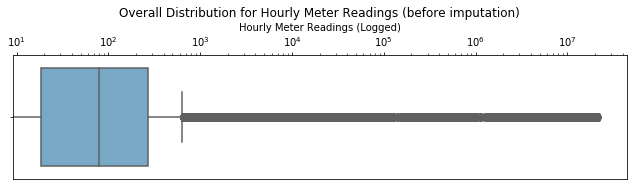

In [8]:
fig = plt.figure(figsize=(11,5))
gs = fig.add_gridspec(2, 1)

ax = fig.add_subplot(gs[0,:])
sns.boxplot(outlier_before_imputation.meter_reading, ax = ax, palette ='Blues')

ax.set_xscale('log')
ax.set_title('Overall Distribution for Hourly Meter Readings (before imputation)')
ax.set_xlabel('Hourly Meter Readings (Logged)')
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()


### site location quick summary

In [356]:
location_buildings = df[['site_id','building_id','primary_use']]

In [358]:
location_buildings=location_buildings.loc[location_buildings.building_id.unique()]

In [373]:
location_buildings_count = pd.pivot_table(location_buildings, index=['site_id'],values=['building_id'],aggfunc=len)
location_buildings_use = pd.pivot_table(location_buildings, index=['site_id'], columns = ['primary_use'],values=['building_id'],aggfunc=len)

In [377]:
location_buildings_count.sort_values(by='building_id', ascending = False, inplace = True)
# location_buildings_use.sort_values(by='building_id', ascending = False, inplace = True)

In [492]:
location_buildings_count

,building_id
site_id,
3,269
0,161
2,135
13,132
9,120
15,104
14,97
5,89
4,82


In [380]:
location_buildings_use['total_by_site'] = location_buildings_use.sum(axis = 1)

In [386]:
location_buildings_use = location_buildings_use.unstack().reset_index().drop('level_0', axis=1)
pivot_use_location_buildings_usedate_test= location_buildings_use.rename(columns = {0:'primary_use'})


In [396]:
primary_use_id = {location_buildings_use.primary_use.unique()[i]:i for i in range(0,len(location_buildings_use.primary_use.unique())-1)}

In [412]:
list(primary_use_id.keys())

['Education',
 'Entertainment/public assembly',
 'Food sales and service',
 'Healthcare',
 'Lodging/residential',
 'Manufacturing/industrial',
 'Office',
 'Other',
 'Parking',
 'Public services',
 'Religious worship',
 'Retail',
 'Services',
 'Technology/science',
 'Utility',
 'Warehouse/storage']

In [402]:
location_buildings['primary_use_id']= location_buildings['primary_use'].map(primary_use_id)

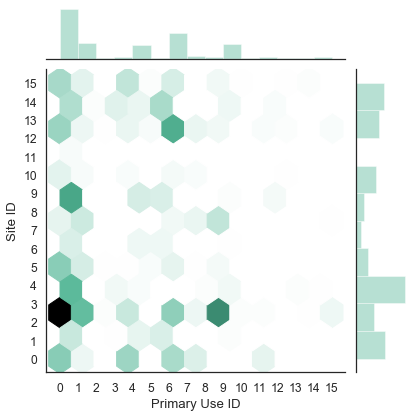

In [443]:
g = sns.jointplot(location_buildings.primary_use_id, location_buildings.site_id, kind="hex", color="#4CB391", height= 6)
g.ax_joint.set_xticks(np.linspace(0,15, endpoint = True, num = 16,dtype = int))
g.ax_joint.set_yticks(np.linspace(0,15, endpoint = True, num = 16,dtype = int))
g.set_axis_labels("Primary Use ID", "Site ID")
plt.show()

In [418]:
g.ax_joint.get_xticks()

array([-2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5])

In [444]:
location_buildings_use = pd.pivot_table(location_buildings, index=['site_id'], columns = ['primary_use'],values=['building_id'],aggfunc=len)

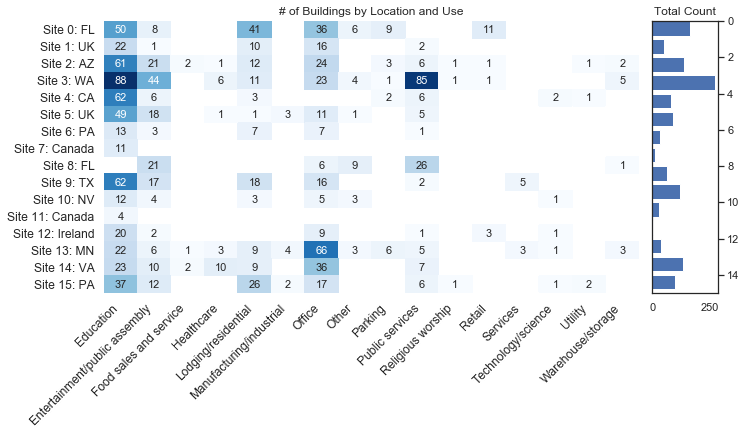

In [722]:
fig = plt.figure(figsize=(11,5))

gs = fig.add_gridspec(1, 8)

ax = fig.add_subplot(gs[0:-1])
sns.set(style='white')
xticks =np.array(list(primary_use_id.keys()))
yticks = np.array(list(site_id_location.values()))
sns.heatmap(location_buildings_use, cmap ='Blues', xticklabels=xticks,\
            yticklabels=yticks,cbar = False,annot=True, ax = ax, annot_kws={'size':11},)
ax.set_xticklabels(xticks, rotation=45, ha='right')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title ('# of Buildings by Location and Use')

ax2 = fig.add_subplot(gs[-1:])
ax2.barh(location_buildings_count.index, location_buildings_count.building_id, align = 'edge')
ax2.invert_yaxis()
ax2.set_ylim(15,0)
ax2.yaxis.tick_right()
ax2.set_title('Total Count')
plt.legend = False
plt.show()

In [507]:
location_buildings_count.building_id

site_id
3     269
0     161
2     135
13    132
9     120
15    104
14     97
5      89
4      82
8      63
1      51
12     36
6      31
10     28
7      11
11      4
Name: building_id, dtype: int64

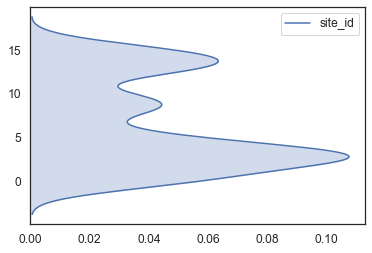

In [470]:
sns.kdeplot(location_buildings.site_id, shade=True, vertical=True,)

### Building meta

In [711]:
building_meta = df[['year_built','meter_reading','date', 'building_id','site_id']]
building_meta= building_meta.loc[building_meta.building_id.unique()]
building_meta['age'] =2019-building_meta.year_built


In [718]:
pivot_building_type = pd.pivot_table(building_meta, index=['site_id'], columns=['year_built'],values=['building_id'],aggfunc=len)

In [719]:
building_meta_count = pd.DataFrame(building_meta.groupby(['year_built'])['building_id'].count())

In [755]:
building_meta_meter = pd.pivot_table(building_meta, index=['date'], columns=['building_id'],values=['meter_reading'],aggfunc=np.sum, margins=True)
building_meta_meter.sort_values(by=('meter_reading', 'All'), ascending=False,inplace=True)
building_meta_meter = building_meta_meter.unstack().reset_index().drop('level_0', axis=1)
building_meta_meter= building_meta_meter.rename(columns = {0:'meter_reading'})
building_meta_meter= building_meta_meter.loc[building_meta_meter.meter_reading != 'All']
building_meta_meter= building_meta_meter.loc[building_meta_meter.date != 'All']

C:\Users\yingh\Anaconda3\envs\W200\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [759]:
merged = pd.merge(building_meta_meter, building_meta[['year_built', 'site_id']], left_index=True, right_index=True)

In [760]:
merged_pivot = pd.pivot_table(merged, index=['site_id'], columns=['year_built'],values=['meter_reading'],aggfunc=np.mean, margins=True)

In [763]:
x = pd.DataFrame(merged.groupby('year_built')['meter_reading'].mean())

In [770]:
building_meta_count['percent']= building_meta_count['building_id']/1449

In [772]:
building_meta_count.sort_values(by='percent')

,building_id,percent
year_built,,
1922.0,1,0.000690
1905.0,1,0.000690
1934.0,1,0.000690
1944.0,1,0.000690
1918.0,1,0.000690
1946.0,1,0.000690
2017.0,2,0.001380
1998.0,2,0.001380
2015.0,2,0.001380


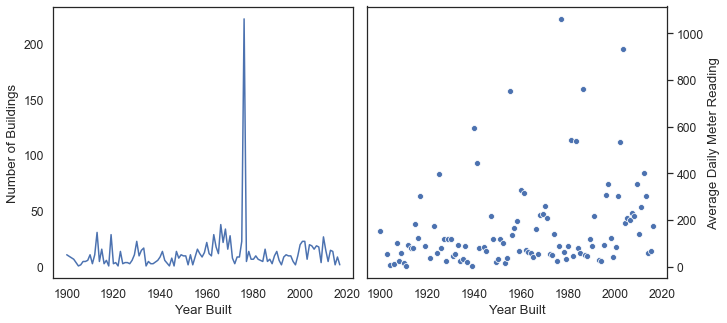

In [768]:
fig = plt.figure(figsize=(11,5))

gs = fig.add_gridspec(1, 8)
sns.set(style= 'white', font_scale =1.1)
ax = fig.add_subplot(gs[0:-4])
ax.set_ylabel('Number of Buildings')
sns.lineplot(building_meta_count.index,building_meta_count['building_id'])
ax.set_xlabel('Year Built')
ax.set_ylabel('Number of Buildings')

ax1 = fig.add_subplot(gs[-4:])
sns.scatterplot(x.index, x.meter_reading, ax=ax1)
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")
ax1.set_xlabel('Year Built')
ax1.set_ylabel('Average Daily Meter Reading')
plt.show()
# building_meta

In [ ]:
g = sns.jointplot(location_buildings.primary_use_id, location_buildings.site_id, kind="hex", color="#4CB391", height= 6)
g.ax_joint.set_xticks(np.linspace(0,15, endpoint = True, num = 16,dtype = int))
g.ax_joint.set_yticks(np.linspace(0,15, endpoint = True, num = 16,dtype = int))
g.set_axis_labels("Primary Use ID", "Site ID")
plt.show()

In [745]:
ax1.get_xticklabels()

<a list of 23 Text xticklabel objects>

In [773]:
train_df.shape

(20216100, 4)

### Site 7 vs. 11

In [6]:
site7= df.loc[(df.site_id==7) ]
site11 = df.loc[ (df.site_id == 11) ]
site7and11 = df.loc[(df.site_id==7) | (df.site_id == 11)  ]

In [7]:
site7and11.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,time_index,...,timestamp_utc,wind_direction,wind_speed,timezone,country_code,location,dst,local_time,date,month
765,791,0,2016-01-01,919.30,7,Education,150695,1970.0,5.0,0,...,2016-01-01 05:00:00,270.0,2.1,Canada/Eastern,CA,Montreal/Ottawa,0.0,2016-01-01,2016-01-01,1
766,793,0,2016-01-01,898.31,7,Education,150695,1964.0,6.0,0,...,2016-01-01 05:00:00,270.0,2.1,Canada/Eastern,CA,Montreal/Ottawa,0.0,2016-01-01,2016-01-01,1
767,794,0,2016-01-01,2994.05,7,Education,731945,1969.0,11.0,0,...,2016-01-01 05:00:00,270.0,2.1,Canada/Eastern,CA,Montreal/Ottawa,0.0,2016-01-01,2016-01-01,1
768,795,0,2016-01-01,2179.16,7,Education,387500,1960.0,6.0,0,...,2016-01-01 05:00:00,270.0,2.1,Canada/Eastern,CA,Montreal/Ottawa,0.0,2016-01-01,2016-01-01,1
769,796,0,2016-01-01,597.80,7,Education,226042,1965.0,2.0,0,...,2016-01-01 05:00:00,270.0,2.1,Canada/Eastern,CA,Montreal/Ottawa,0.0,2016-01-01,2016-01-01,1


In [8]:
pivot_date_type = pd.pivot_table(site7and11, index=['site_id'],values=['square_feet'],aggfunc=np.mean)

In [10]:
site7and11.groupby('site_id').median()

,building_id,meter,meter_reading,square_feet,year_built,floor_count,time_index,day_of_week,hour_of_day,index,...,outlier,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,dst,month
site_id,,,,,,,,,,,,,,,,,,,,,
7,797.0,0.0,1948.140,387500.0,1965.0,6.0,4369,3.0,12,5942700.5,...,3756.949708,7.2,NaN,2.1,5.0,1015.2,230.0,3.1,1.0,7.0
11,1030.0,0.0,238.656,93206.0,1965.0,4.0,4407,3.0,12,5995528.0,...,528.095053,7.4,NaN,2.3,5.0,1015.2,230.0,3.1,1.0,7.0


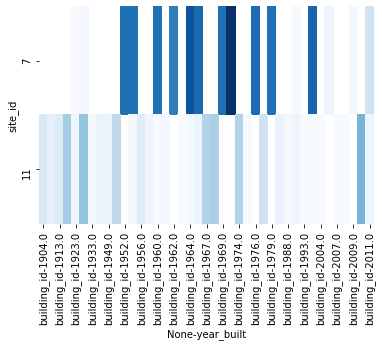

In [80]:
sns.heatmap(pivot_date_type, cmap ='Blues', cbar = False)


In [81]:
site11.building_id.nunique()

5

In [82]:
site7.building_id.nunique()

12

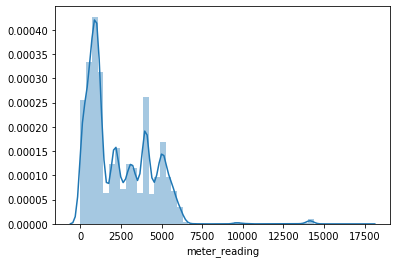

In [87]:
sns.distplot(site7.meter_reading, bins = 50, label ='Canada (Site 7)')

In [11]:
site7.groupby('building_id').meter_reading.agg('mean')

building_id
791    1086.465732
793     696.859636
794    4124.908340
795    2431.405850
796     644.818791
797    3106.007216
798    1769.643273
799    4020.545474
800     146.425159
801    4650.067009
802    1103.046483
803    5073.575629
Name: meter_reading, dtype: float64

In [12]:
site7.groupby('building_id').meter_reading.agg('median')

building_id
791    1021.250000
793     663.440000
794    3912.290000
795    2184.870000
796     575.030000
797    2655.150000
798    1129.310000
799    4015.252819
800     126.520000
801    4130.830000
802    1097.556345
803    5063.473038
Name: meter_reading, dtype: float64

In [14]:
canadian_buildings = site7.loc[(site7.building_id ==794) | (site7.building_id ==799)| (site7.building_id ==801)| (site7.building_id ==803)]

In [33]:
canadian_outlier = pd.DataFrame(canadian_buildings.groupby('building_id').square_feet.agg('mean'))

In [34]:
canadian_outlier

,square_feet
building_id,
794,731945
799,527431
801,484376
803,182986


In [27]:
x = pd.DataFrame(df.groupby('building_id').square_feet.mean())

In [30]:
other_building = x.loc[~x.index.isin([794,799,801,803])]

In [35]:
canadian_outlier.square_feet.mean()

481684.5

In [32]:
other_building.square_feet.mean()

91099.10149041873

In [36]:
canadian_outlier.square_feet.mean()/ other_building.square_feet.mean()

5.287478055430226

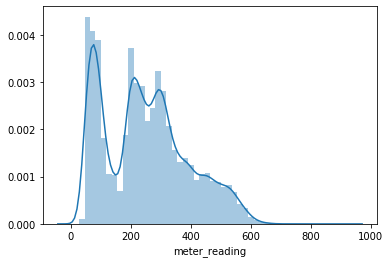

In [88]:
sns.distplot(site11.meter_reading, bins = 50, label ='Canada (Site 7)')

In [49]:
nonsite7.square_feet.describe()

count      1401.000000
mean      89875.252677
std      107085.821598
min         283.000000
25%       22400.000000
50%       57189.000000
75%      112536.000000
max      875000.000000
Name: square_feet, dtype: float64

In [109]:
site7all = df.loc[df.site_id ==7]

In [104]:
x = pd.DataFrame(site11.groupby('building_id')['meter_reading'])

In [105]:
x

,0,1
0,1028,443228 65.000 444614 136.000 446001...
1,1029,995 246.000 2380 246.000 3767 ...
2,1030,996 50.000 2381 51.000 3768 ...
3,1031,997 207.5 2382 207.5 3769 ...
4,1032,998 206.0 2383 208.0 3770 ...


In [143]:
site11sqft = pd.DataFrame(df.loc[df.site_id == 11].groupby('building_id')['square_feet'].mean())

In [145]:
nonsite7or11 = pd.DataFrame(df.loc[(df.site_id != 7)&(df.site_id != 11)].groupby('building_id')['square_feet'].mean())

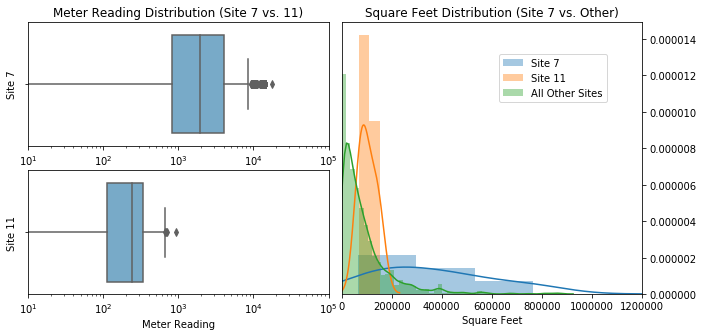

In [146]:
fig = plt.figure(figsize=(11,5))

gs = fig.add_gridspec(2, 8)

ax1 = fig.add_subplot(gs[:-1,:-4])
sns.boxplot(site7all.meter_reading, ax = ax1, palette ='Blues')
ax1.set_title ('Meter Reading Distribution (Site 7 vs. 11)')
ax1.set_xscale ('log')
ax1.set_ylabel('Site 7')
ax1.set_xlim(10,100000)

ax2 = fig.add_subplot(gs[-1:,:-4], sharex=ax1)
sns.boxplot(site11.meter_reading, ax = ax2, palette ='Blues')
ax2.set_ylabel('Site 11')
ax2.set_xlabel ('Meter Reading')

ax3 = fig.add_subplot(gs[:,-4:])
l1= sns.distplot(site7.square_feet, ax = ax3, label = 'Site 7')
l2 =sns.distplot(site11sqft.square_feet, ax = ax3, label = 'Site 11')
l3= sns.distplot(nonsite7or11.square_feet, ax = ax3, label = 'All Other Sites')
ax3.set_xlim (0, 1200000)

ax3.yaxis.set_label_position("right")
ax3.set_xlabel('Square Feet')
ax3.yaxis.tick_right()
ax3.set_title('Square Feet Distribution (Site 7 vs. Other)')
ax3.legend(labels=['Site 7','Site 11','All Other Sites'], bbox_to_anchor=(0.9, 0.9))
plt.show()

In [148]:
site7or11 = df.loc[(df.site_id==7) |(df.site_id == 11)]